# Opcode and resource usage - data preparation

#### Maria Silva, March 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")
op_dir = os.path.join(data_dir, "opcode_gas_usage")

## 2. Load data

Now, let's load the data. We will start by loading the gas map. For each opcode, this table contains the gas cost, split by resource type.

In [3]:
gas_map_df = pd.read_csv(os.path.join(data_dir, "gas_by_resource.csv"))
gas_map_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   op         88 non-null     object 
 1   compute    88 non-null     int64  
 2   history    88 non-null     float64
 3   state      88 non-null     float64
 4   read       88 non-null     float64
 5   bandwidth  88 non-null     float64
 6   bloom      88 non-null     float64
 7   mem_quad   88 non-null     float64
 8   total      88 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 6.3+ KB


Now we can load the opcodes used for blocks 22000000 to 22001999.


In [4]:
# Load first 2000 blocks
file_dir = os.path.join(op_dir, "opcode_gas_usage_22000000_22001999.parquet")
raw_usage_df = pd.read_parquet(file_dir)
raw_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15033306 entries, 0 to 15033305
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   op            object 
 1   gas_cost      float64
 2   count         float64
 3   tx_hash       object 
 4   block_height  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 573.5+ MB


In [5]:
raw_usage_df["block_height"].agg(["min", "max"])

min    22000000
max    22001999
Name: block_height, dtype: int64

Finally, we can load the gas used per transaction for the same blocks.

In [6]:
tx_gas_usage_df = pd.read_parquet(os.path.join(data_dir, "tx_gas_usage_22000000_22001999.parquet"))
tx_gas_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290953 entries, 0 to 290952
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   block_height      290953 non-null  int64 
 1   transaction_hash  290953 non-null  object
 2   gas_used          290953 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.7+ MB


## 3. Missing data

Our data can have transactions with missing data for two reasons:
1. They are executing a single ETH transfer and thus have no opcode traces (these will be a majority of the transactions).
2. Their traces were too large to parse locally and, thus, we stopped the execution and returned an empty trace (these are a small fraction, usually 1 transaction per block or less).

We can see the percentage of these transactions by block.

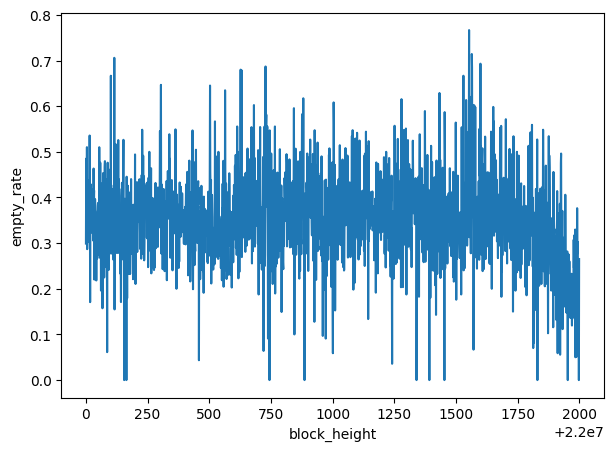

In [7]:
total_by_block = raw_usage_df.groupby("block_height")[["tx_hash"]].nunique()
total_by_block.columns = ["total"]

non_empty_by_block = (
    raw_usage_df[raw_usage_df["op"].notna()]
    .groupby("block_height")[["tx_hash"]]
    .nunique()
)
non_empty_by_block.columns = ["non_empty"]

by_block_df = pd.concat([total_by_block, non_empty_by_block], axis=1)
by_block_df["empty_rate"] = 1 - by_block_df["non_empty"] / by_block_df["total"]

plt.figure(figsize=(7, 5))
sns.lineplot(data=by_block_df, x="block_height", y="empty_rate")
plt.show()

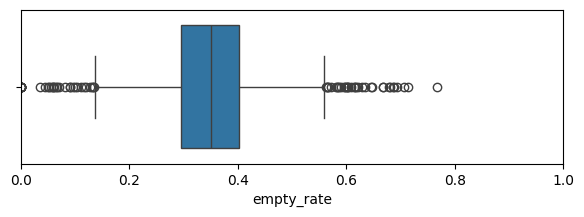

In [8]:
plt.figure(figsize=(7, 2))
sns.boxplot(data=by_block_df, x="empty_rate")
plt.xlim(0, 1)
plt.show()

Do we have any other empty fields? Let's check if there are any opcodes with empty gas cost.

In [9]:
raw_usage_df[(raw_usage_df["op"].notna()) & (raw_usage_df["gas_cost"].isna())]

,op,gas_cost,count,tx_hash,block_height


No, the only empty cells come the transactions with too large traces.

## 4. Compare opcode mapping

Now, we can check if the opcodes in the data match the gas map. First, we drop the rows with empty opcodes and compute the total gas cost for each opcode.

In [10]:
usage_df = raw_usage_df.dropna().copy()
usage_df["total_gas_cost"] = usage_df["gas_cost"] * usage_df["count"]

opcode_usage_df = (
    usage_df.groupby("op")
    .agg({"total_gas_cost": "sum", "count": "sum", "gas_cost": "mean"})
    .dropna()
)
opcode_usage_df

,total_gas_cost,count,gas_cost
op,,,
ADD,164199063.0,54733021.0,3.000000
ADDMOD,5626680.0,703335.0,8.000000
ADDRESS,1228652.0,614326.0,2.000000
AND,77795949.0,25931983.0,3.000000
BALANCE,1473400.0,5509.0,291.935484
...,...,...,...
SWAP9,1674261.0,558087.0,3.000000
TIMESTAMP,801254.0,400627.0,2.000000
TLOAD,8707900.0,87079.0,100.000000


And now, we can joint both dataframes on the opcode column in order to compare them.

In [11]:
compare_df = opcode_usage_df.merge(
    gas_map_df[["op", "total"]], how="outer", on="op"
).sort_values("op")
compare_df

,op,total_gas_cost,count,gas_cost,total
0,ADD,164199063.0,54733021.0,3.000000,3.0000
1,ADDMOD,5626680.0,703335.0,8.000000,8.0000
2,ADDRESS,1228652.0,614326.0,2.000000,2.0000
3,AND,77795949.0,25931983.0,3.000000,3.0000
4,BALANCE,1473400.0,5509.0,291.935484,749.6713
...,...,...,...,...,...
180,SWAP9,1674261.0,558087.0,3.000000,NaN
181,TIMESTAMP,801254.0,400627.0,2.000000,2.0000
182,TLOAD,8707900.0,87079.0,100.000000,NaN
183,TSTORE,8172500.0,81725.0,100.000000,NaN


### Missing opcodes

The first thing we will check are missing opcodes. In other words, are we observing opcodes in the selected blocks that are not in the gas map?

In [12]:
compare_df[compare_df["total"].isna()]["op"].values

array(['BASEFEE', 'BLOBBASEFEE', 'BLOBHASH', 'CALL', 'CALLDATACOPY',
       'CHAINID', 'CODECOPY', 'CREATE2', 'DELEGATECALL', 'DUP1', 'DUP10',
       'DUP11', 'DUP12', 'DUP13', 'DUP14', 'DUP15', 'DUP16', 'DUP2',
       'DUP3', 'DUP4', 'DUP5', 'DUP6', 'DUP7', 'DUP8', 'DUP9', 'EXP',
       'EXTCODECOPY', 'EXTCODEHASH', 'INVALID', 'KECCAK256', 'LOG0',
       'LOG1', 'LOG2', 'LOG3', 'LOG4', 'MCOPY', 'PUSH0', 'PUSH1',
       'PUSH10', 'PUSH11', 'PUSH12', 'PUSH13', 'PUSH14', 'PUSH15',
       'PUSH16', 'PUSH17', 'PUSH18', 'PUSH19', 'PUSH2', 'PUSH20',
       'PUSH21', 'PUSH22', 'PUSH23', 'PUSH24', 'PUSH25', 'PUSH26',
       'PUSH27', 'PUSH28', 'PUSH29', 'PUSH3', 'PUSH30', 'PUSH31',
       'PUSH32', 'PUSH4', 'PUSH5', 'PUSH6', 'PUSH7', 'PUSH8', 'PUSH9',
       'RETURNDATACOPY', 'RETURNDATASIZE', 'REVERT', 'SAR', 'SELFBALANCE',
       'SELFDESTRUCT', 'SHL', 'SHR', 'SSTORE', 'STATICCALL', 'SWAP1',
       'SWAP10', 'SWAP11', 'SWAP12', 'SWAP13', 'SWAP14', 'SWAP15',
       'SWAP16', 'SWAP2', 'SWAP3',

We see some opcodes that are repeated (e.g. `DUP1`, `DUP2`, etc.). They could be the same opcode with the same gas cost. In that case, we can simply put them all in the same label (in this case, `DUP`). Let's check if that's the case:

In [13]:
compare_df[compare_df["op"].str.startswith("DUP")]

,op,total_gas_cost,count,gas_cost,total
29,DUP,NaN,NaN,NaN,3.0
30,DUP1,141069354.0,47023118.0,3.0,NaN
31,DUP10,6266325.0,2088775.0,3.0,NaN
32,DUP11,4259082.0,1419694.0,3.0,NaN
33,DUP12,3515208.0,1171736.0,3.0,NaN
34,DUP13,2702241.0,900747.0,3.0,NaN
35,DUP14,2442597.0,814199.0,3.0,NaN
36,DUP15,992085.0,330695.0,3.0,NaN
37,DUP16,585549.0,195183.0,3.0,NaN
38,DUP2,190707438.0,63569146.0,3.0,NaN


In [14]:
compare_df[compare_df["op"].str.startswith("SWAP")]

,op,total_gas_cost,count,gas_cost,total
164,SWAP,NaN,NaN,NaN,3.0
165,SWAP1,226051884.0,75350628.0,3.0,NaN
166,SWAP10,1039383.0,346461.0,3.0,NaN
167,SWAP11,1070436.0,356812.0,3.0,NaN
168,SWAP12,649650.0,216550.0,3.0,NaN
169,SWAP13,728877.0,242959.0,3.0,NaN
170,SWAP14,178428.0,59476.0,3.0,NaN
171,SWAP15,146532.0,48844.0,3.0,NaN
172,SWAP16,17964.0,5988.0,3.0,NaN
173,SWAP2,94291989.0,31430663.0,3.0,NaN


`DUP` and `SWAP` are exactly as expected. Thus, we can safely combine them into a single opcode label. Now, for `PUSH`, we see that `PUSH0` has a different gas consumption, while all the others have the same gas consumption. In this case, we can have the `PUSH0` as a new label with a computation resource of 2 and aggregate the other `PUSH` opcodes into a single label. 

We should note that these label alterations are consistent with the [opcodes overview page](https://ethereum.org/en/developers/docs/evm/opcodes/).

In [23]:
compare_df[compare_df["op"].str.startswith("PUSH")]

,op,total_gas_cost,count,gas_cost,total
100,PUSH,NaN,NaN,NaN,3.0
101,PUSH0,11816138.0,5908069.0,2.0,NaN
102,PUSH1,441996381.0,147332127.0,3.0,NaN
103,PUSH10,250569.0,83523.0,3.0,NaN
104,PUSH11,131640.0,43880.0,3.0,NaN
105,PUSH12,629643.0,209881.0,3.0,NaN
106,PUSH13,207108.0,69036.0,3.0,NaN
107,PUSH14,1705200.0,568400.0,3.0,NaN
108,PUSH15,683049.0,227683.0,3.0,NaN
109,PUSH16,2466468.0,822156.0,3.0,NaN


Finally, the `LOG` opcodes are simply not in the gas map. In addition, their gas cost is defined by:

`gas_cost = 375 + 375 * num_topics + 8 * data_size + mem_expansion_cost`

We need to manually create an entry for them in the map.


In [24]:
compare_df[compare_df["op"].str.startswith("LOG")]

,op,total_gas_cost,count,gas_cost,total
79,LOG0,233671.0,305.0,766.376271,NaN
80,LOG1,141234396.0,80130.0,1840.056433,NaN
81,LOG2,241371081.0,138901.0,1891.444485,NaN
82,LOG3,997653928.0,525286.0,2034.488020,NaN
83,LOG4,124356960.0,46528.0,3029.440855,NaN


The remaining opcodes are listed in the [opcodes overview page](https://ethereum.org/en/developers/docs/evm/opcodes/), so we also need to manually add them to the gas map.

- BASEFEE: 2
- BLOBBASEFEE: 2
- BLOBHASH: 3
- CALL: [AA](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#aa-call-operations)
- CALLDATACOPY: [A3](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a3-copy-operations)
- CHAINID: 2
- CODECOPY: [A3](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a3-copy-operations)
- CREATE2: [A9](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a9-create-operations)
- DELEGATECALL: [AA](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#aa-call-operations)
- EXP: [A1](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a1-exp)
- EXTCODECOPY: [A4](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a4-extcodecopy)
- EXTCODEHASH: [A5](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a5-balance-extcodesize-extcodehash)
- INVALID: 0
- KECCAK256: [A2](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a2-sha3)
- MCOPY: 3+3*words+[A0](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a0-1-memory-expansion)
- RETURNDATACOPY: [A3](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a3-copy-operations)
- RETURNDATASIZE: 2
- REVERT: 0 with [A0-1](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a0-1-memory-expansion)
- SAR: 3
- SELFBALANCE: 5
- SELFDESTRUCT: [AB](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#ab-selfdestruct)
- SHL: 3
- SHR: 3
- SSTORE: [A7](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a7-sstore)
- STATICCALL: [AA](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#aa-call-operations)
- TLOAD: 100
- TSTORE: 100

Let's check if the opcodes with fixed values are consistent with the block data.

In [38]:
op_list = [
    "BASEFEE",
    "BLOBBASEFEE",
    "BLOBHASH",
    "CHAINID",
    "INVALID",
    "RETURNDATASIZE",
    "SAR",
    "SELFBALANCE",
    "SHL",
    "SHR",
    "TLOAD",
    "TSTORE",
]
usage_df[usage_df["op"].isin(op_list)][["op", "gas_cost"]].drop_duplicates().sort_values("op")

,op,gas_cost
2745,BASEFEE,2.0
7057,BLOBBASEFEE,2.0
6944,BLOBHASH,3.0
16,CHAINID,2.0
179592,INVALID,0.0
86,RETURNDATASIZE,2.0
308,SAR,3.0
87,SELFBALANCE,5.0
89,SHL,3.0
90,SHR,3.0


Yep, it looks like things match! Now, we still need to figure out how these gas costs are distributed among the various resources and how to account for the dynamic cost opcodes.

### Gas cost mismatches

Now, we can check if the gas cost for the remaining opcodes matches the opcode gas map.





In [42]:
remain_compare_df = compare_df[["op",  "gas_cost", "total",]].dropna()
remain_compare_df.columns = ["op", "real_gas_cost", "map_gas_cost"]
remain_compare_df[remain_compare_df["real_gas_cost"] != remain_compare_df["map_gas_cost"]]

,op,real_gas_cost,map_gas_cost
4,BALANCE,291.935484,749.671300
23,CREATE,32945.578761,32390.260540
54,EXTCODESIZE,1182.631753,749.671300
87,MLOAD,3.747750,3.000000
90,MSTORE,10.305616,3.000000
91,MSTORE8,3.435414,3.000000
135,RETURN,0.000715,5.000000
153,SLOAD,1297.366838,924.835650
158,STOP,0.000000,5030.126595


Let's compare each case separately with [opcodes overview page](https://ethereum.org/en/developers/docs/evm/opcodes/):

- `BALANCE` and `EXTCODESIZE` are dynamic opcodes that use the [A5](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a5-balance-extcodesize-extcodehash) rule.
- `CREATE` is a dynamic opcode that uses the [A9](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a9-create-operations) rule.
- `MLOAD`, `MSTORE`, and `MSTORE8` use 3 units of gas, but also pay for the memory expansion according to [A0-1](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a0-1-memory-expansion)
- `RETURN` use 0 units of gas, but also pays for the memory expansion according to [A0-1](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a0-1-memory-expansion)
- `SLOAD` is a dynamic opcode that use the [A6](https://github.com/wolflo/evm-opcodes/blob/main/gas.md#a6-sload) rule.
- And `STOP` uses 0 units of gas.

Once again, we need to adjust these entries in the map file and figure out how to deal with the dynamic opcodes.

## 5. Opcode cleanup

In [16]:
clean_usage_df = raw_usage_df.dropna().copy()

# clean up repeated opcodes
clean_usage_df["op"] = np.where(
    clean_usage_df["op"].str.startswith("DUP"), "DUP", clean_usage_df["op"]
)
clean_usage_df["op"] = np.where(
    clean_usage_df["op"].str.startswith("SWAP"), "SWAP", clean_usage_df["op"]
)
clean_usage_df["op"] = np.where(
    (clean_usage_df["op"].str.startswith("PUSH")) & 
    (clean_usage_df["op"]!="PUSH0"), "PUSH", clean_usage_df["op"]
)

# compute total gas cost
clean_usage_df["total_gas_cost"] = clean_usage_df["gas_cost"] * clean_usage_df["count"]

In [20]:
# aggreagte info by opcode
clean_opcode_usage_df =  (
    clean_usage_df
    .groupby("op")
    .agg({"total_gas_cost": "sum", "count": "sum", "gas_cost": "mean"})
    .dropna()
)
clean_opcode_usage_df

,total_gas_cost,count,gas_cost
op,,,
ADD,164199063.0,54733021.0,3.000000
ADDMOD,5626680.0,703335.0,8.000000
ADDRESS,1228652.0,614326.0,2.000000
AND,77795949.0,25931983.0,3.000000
BALANCE,1473400.0,5509.0,291.935484
...,...,...,...
SWAP,449908650.0,149969550.0,3.000000
TIMESTAMP,801254.0,400627.0,2.000000
TLOAD,8707900.0,87079.0,100.000000


In [22]:
clean_opcode_usage_df.index.unique()

Index(['ADD', 'ADDMOD', 'ADDRESS', 'AND', 'BALANCE', 'BASEFEE', 'BLOBBASEFEE',
       'BLOBHASH', 'BLOCKHASH', 'BYTE', 'CALL', 'CALLDATACOPY', 'CALLDATALOAD',
       'CALLDATASIZE', 'CALLER', 'CALLVALUE', 'CHAINID', 'CODECOPY',
       'CODESIZE', 'COINBASE', 'CREATE', 'CREATE2', 'DELEGATECALL',
       'DIFFICULTY', 'DIV', 'DUP', 'EQ', 'EXP', 'EXTCODECOPY', 'EXTCODEHASH',
       'EXTCODESIZE', 'GAS', 'GASLIMIT', 'GASPRICE', 'GT', 'INVALID', 'ISZERO',
       'JUMP', 'JUMPDEST', 'JUMPI', 'KECCAK256', 'LOG0', 'LOG1', 'LOG2',
       'LOG3', 'LOG4', 'LT', 'MCOPY', 'MLOAD', 'MOD', 'MSIZE', 'MSTORE',
       'MSTORE8', 'MUL', 'MULMOD', 'NOT', 'NUMBER', 'OR', 'ORIGIN', 'PC',
       'POP', 'PUSH', 'PUSH0', 'RETURN', 'RETURNDATACOPY', 'RETURNDATASIZE',
       'REVERT', 'SAR', 'SDIV', 'SELFBALANCE', 'SELFDESTRUCT', 'SGT', 'SHL',
       'SHR', 'SIGNEXTEND', 'SLOAD', 'SLT', 'SMOD', 'SSTORE', 'STATICCALL',
       'STOP', 'SUB', 'SWAP', 'TIMESTAMP', 'TLOAD', 'TSTORE', 'XOR'],
      dtype='object', name

Still missing:
- Add tx gas usage data and check consistency -> should we use a new opcode for ETH transfers?
- How to account for the variable cost opcodes?
- Fix the opcodes that are not in the map